C:


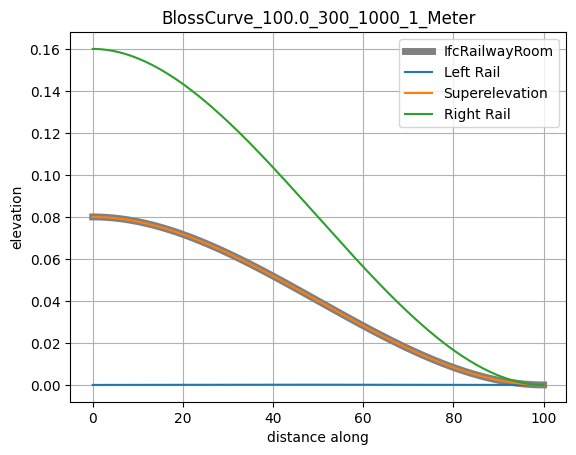

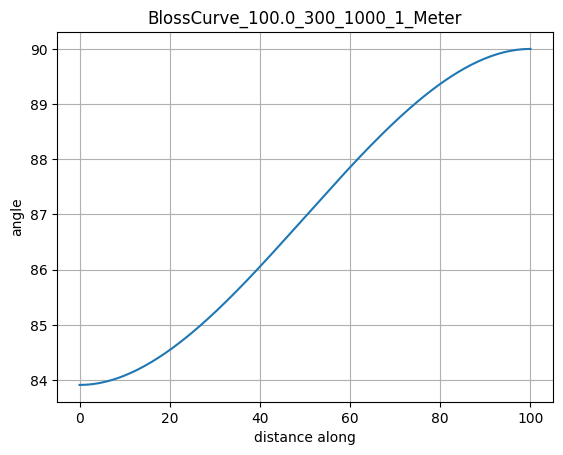

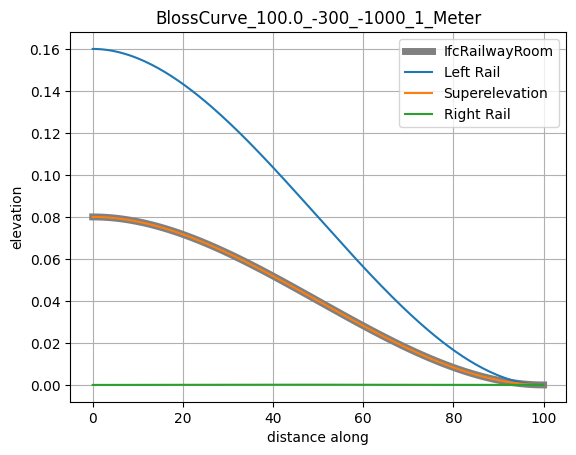

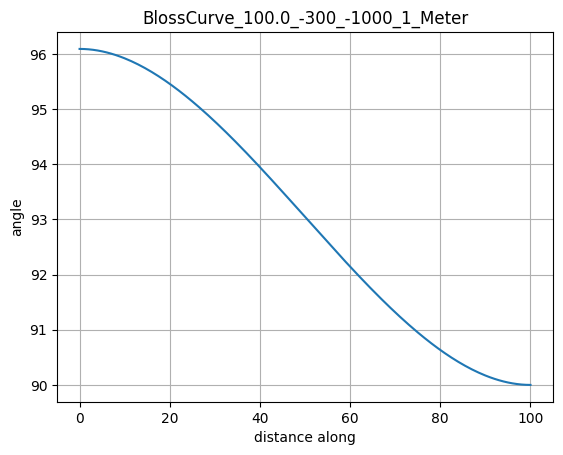

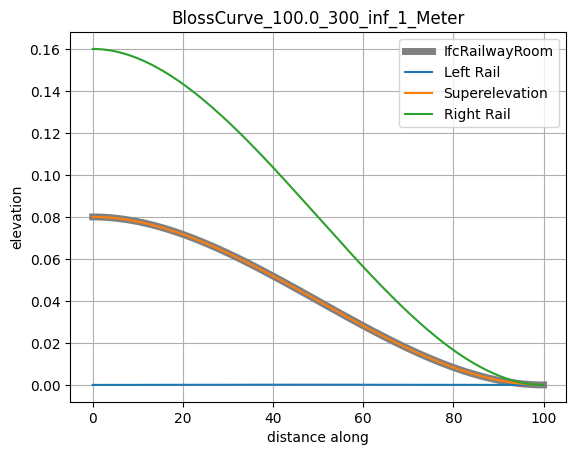

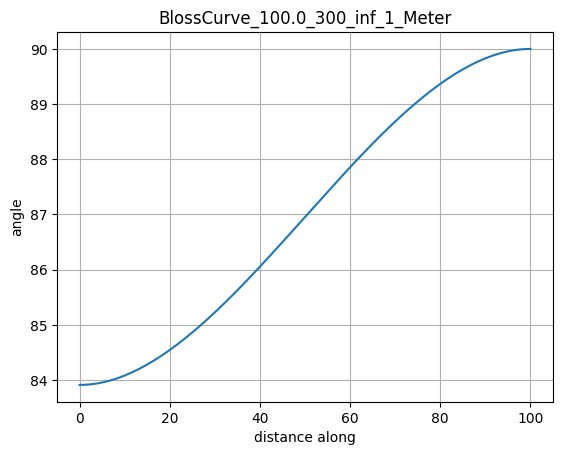

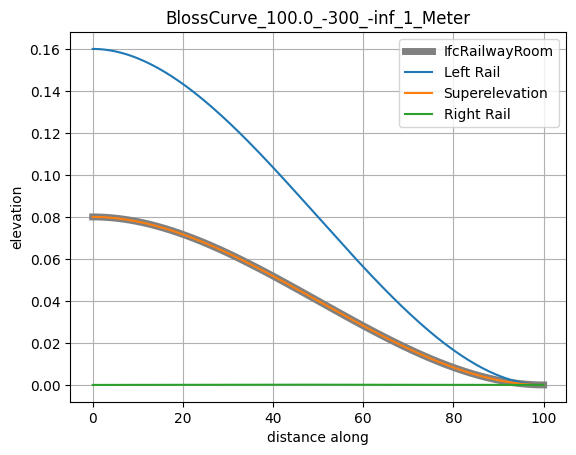

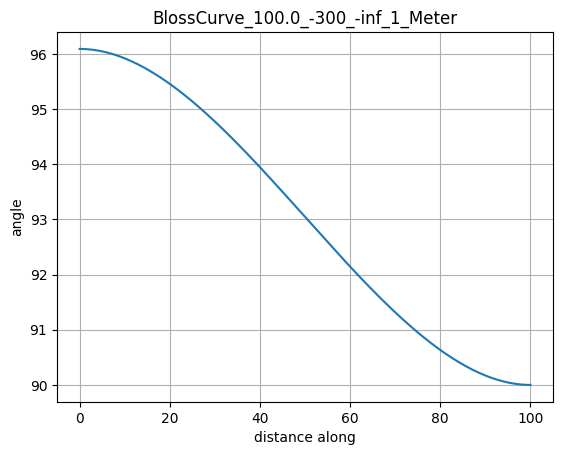

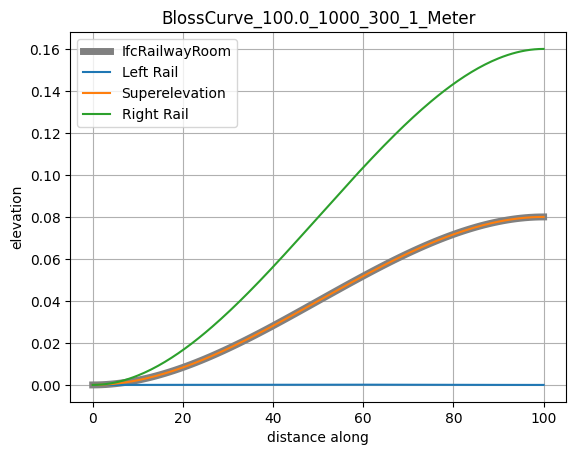

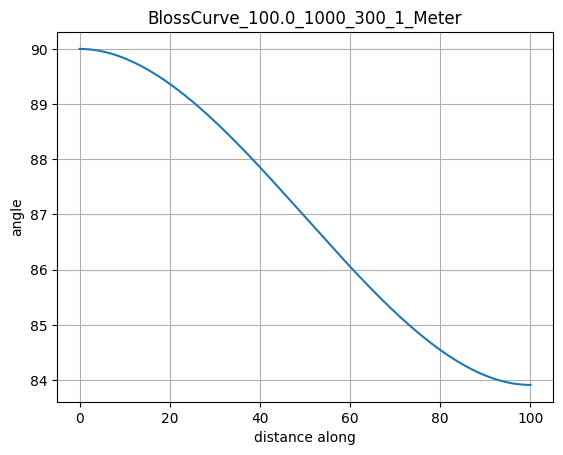

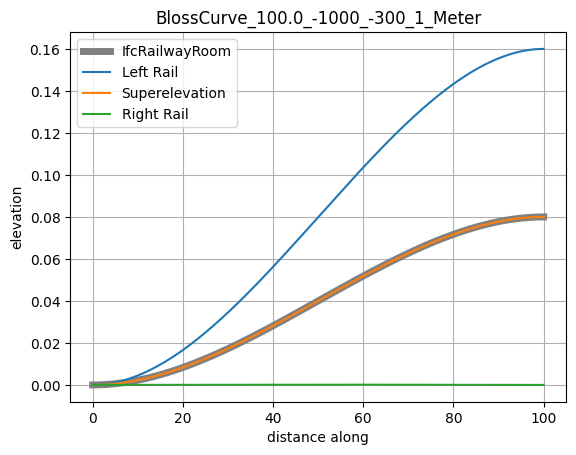

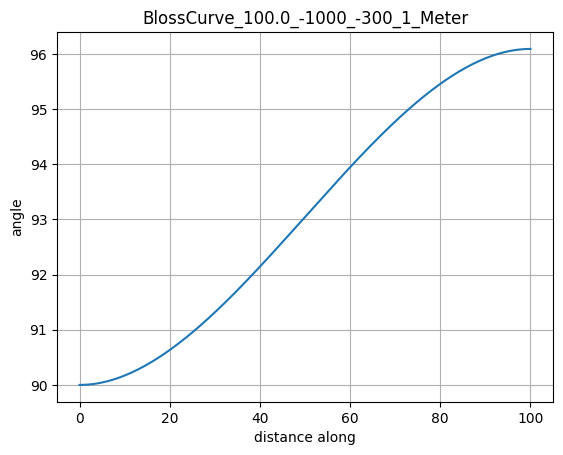

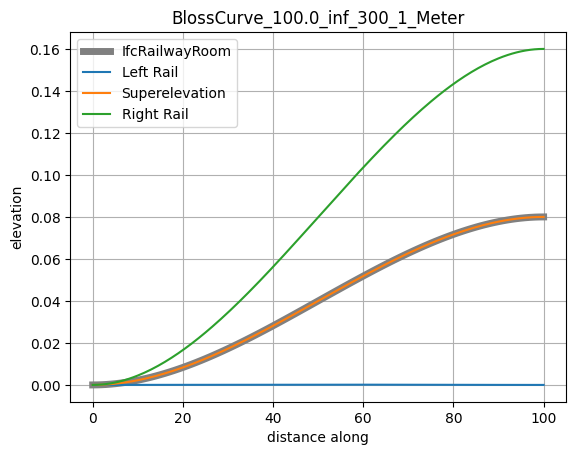

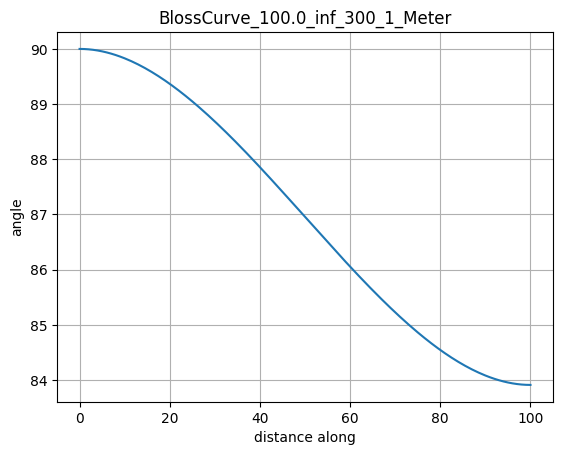

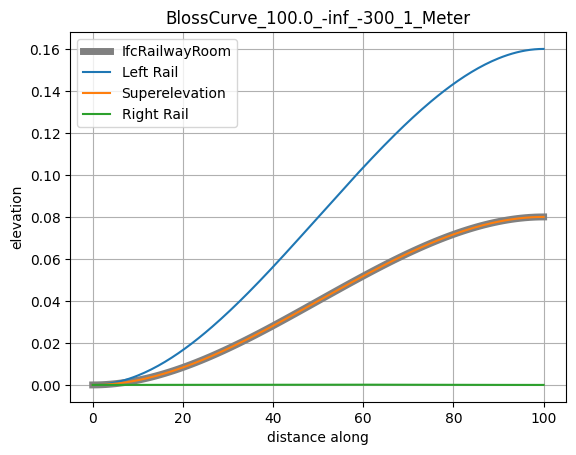

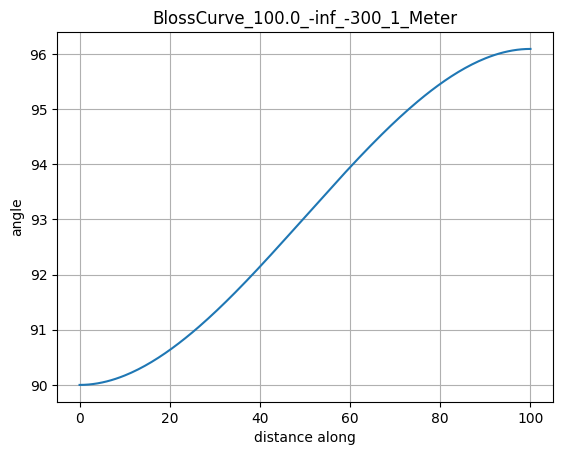

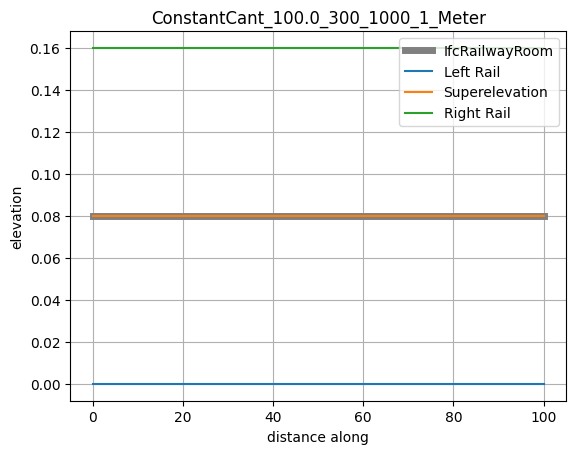

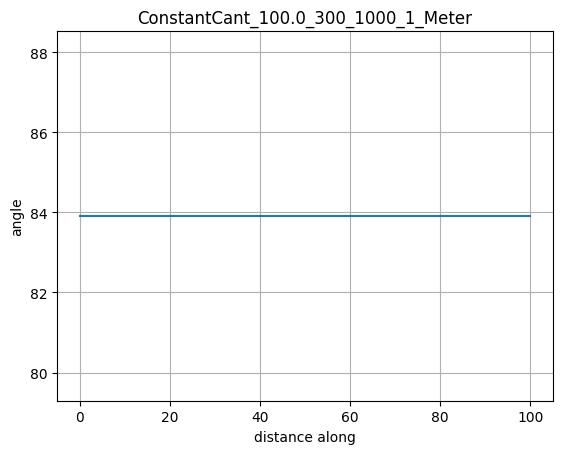

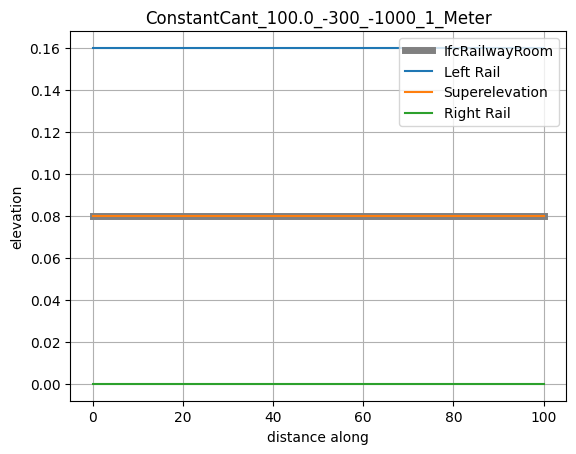

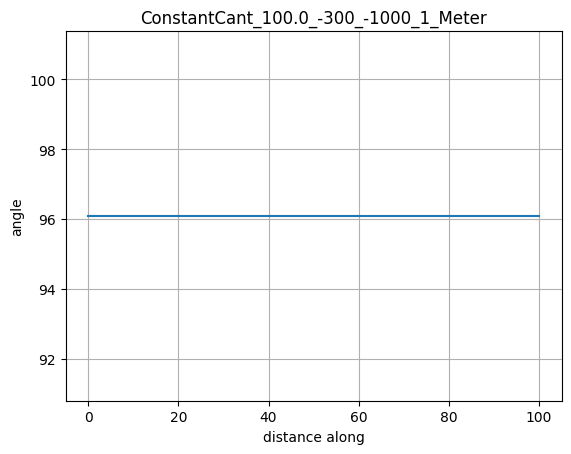

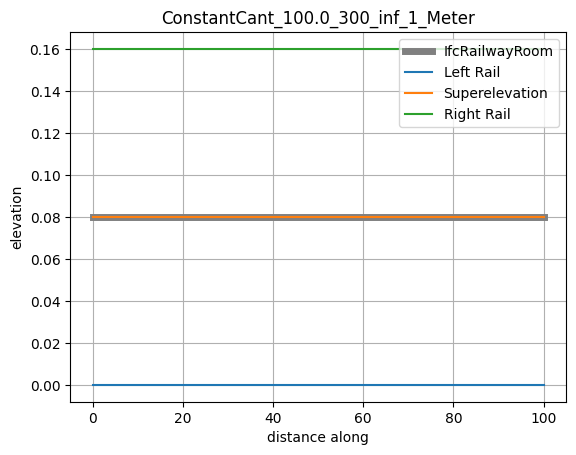

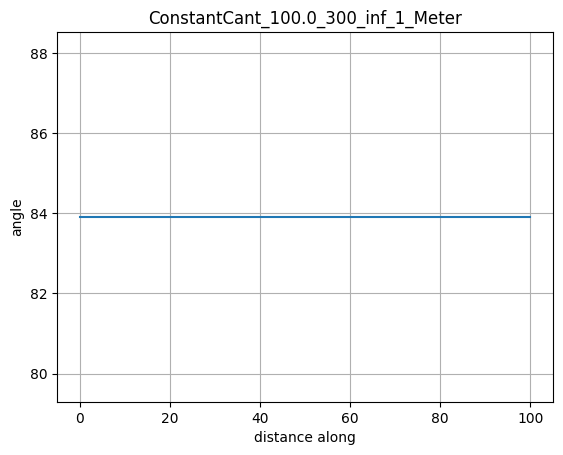

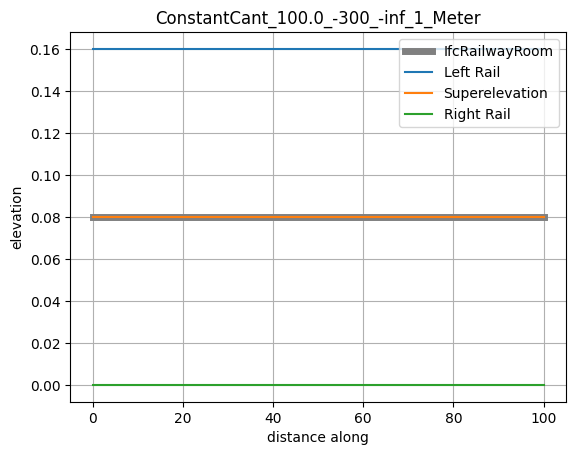

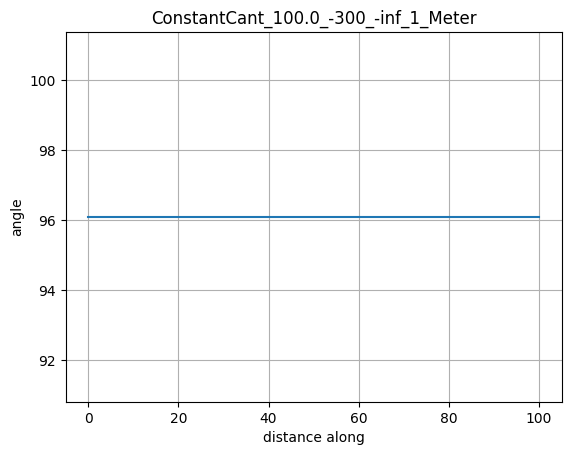

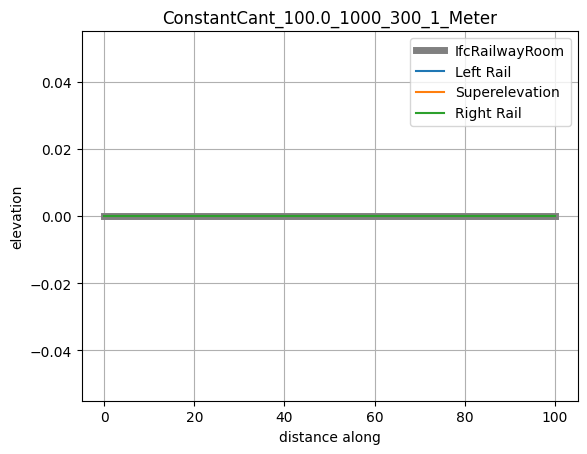

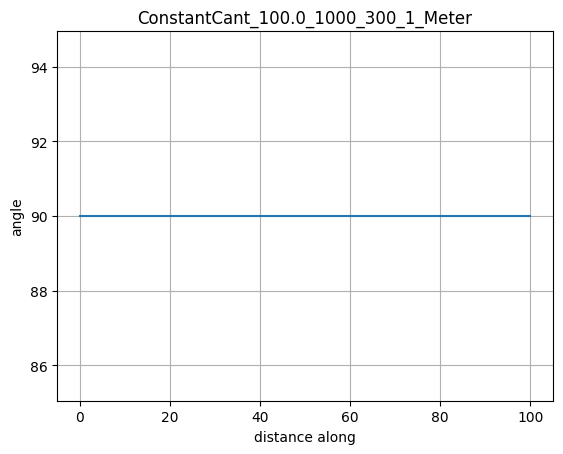

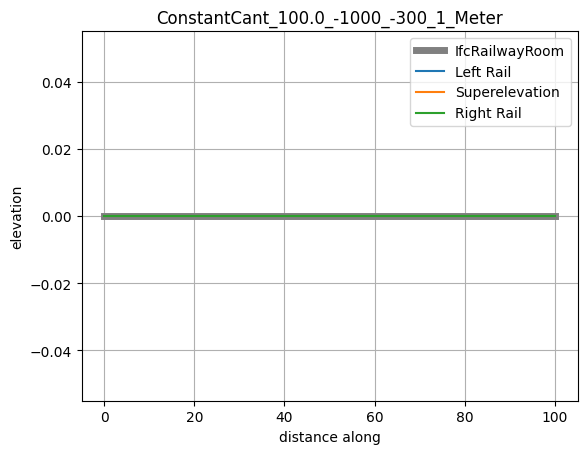

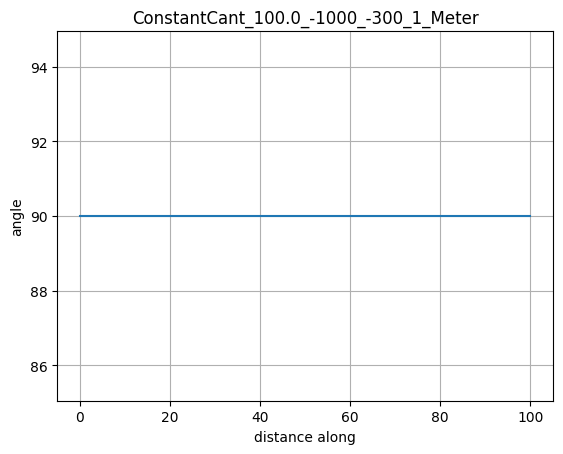

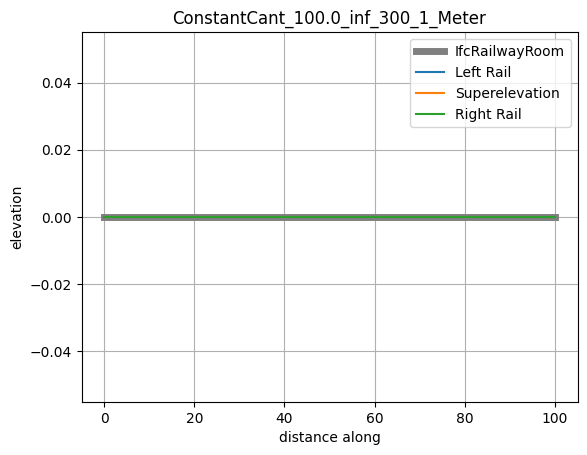

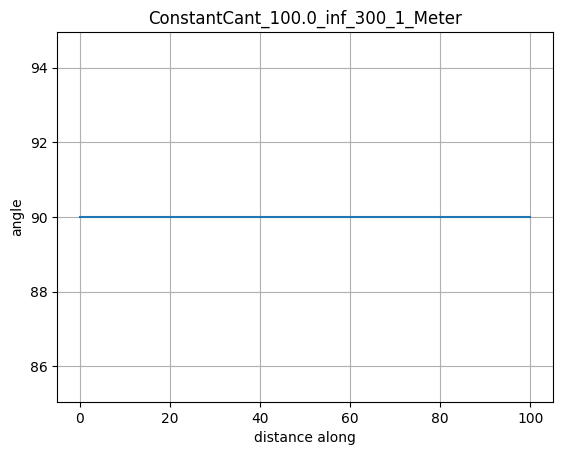

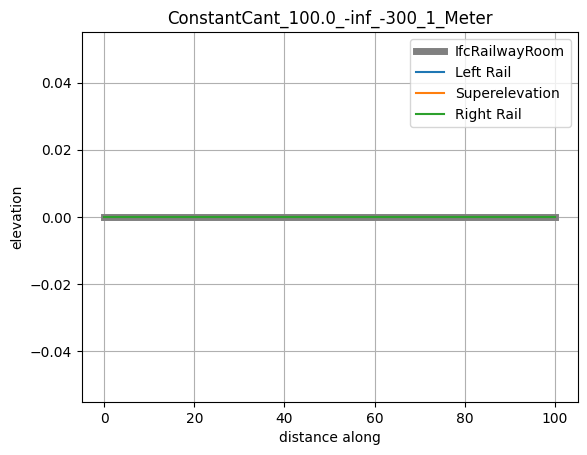

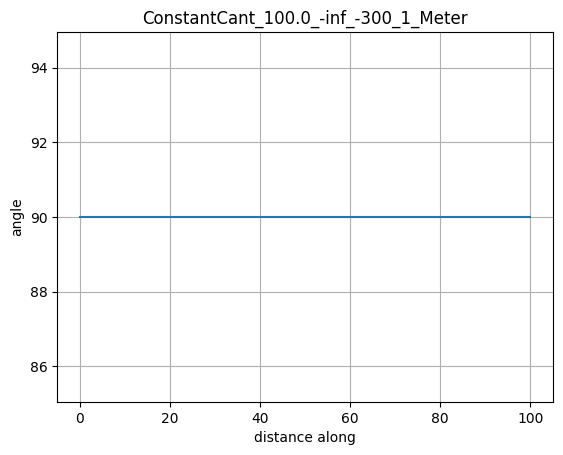

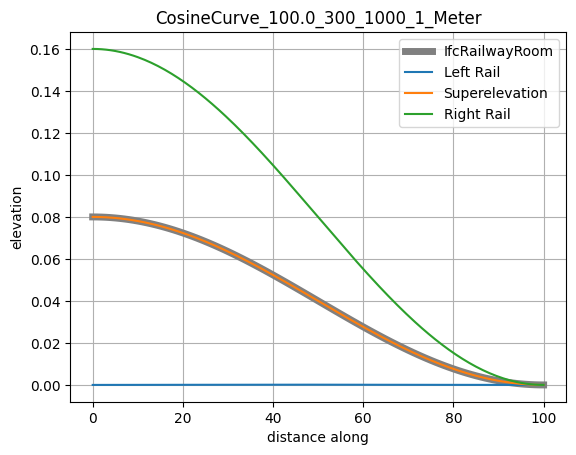

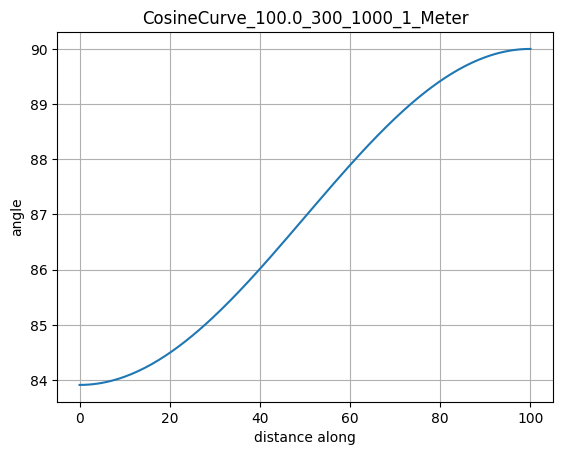

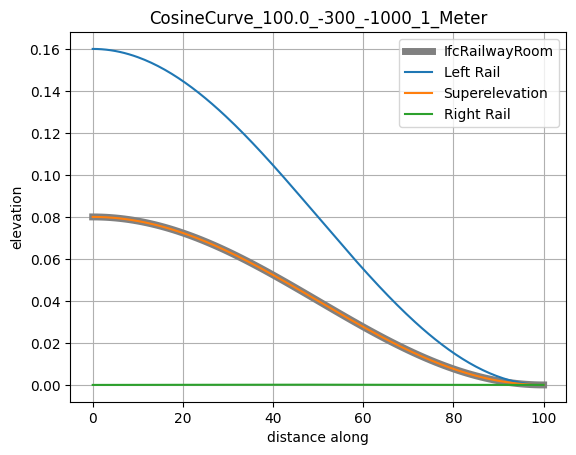

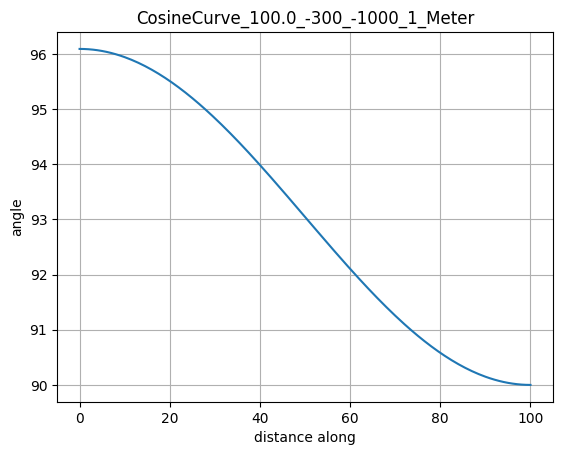

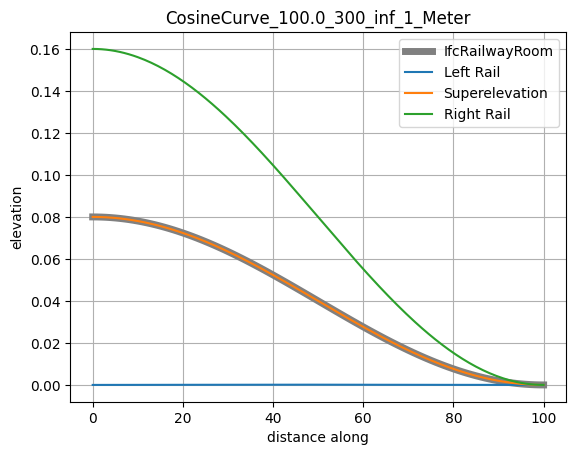

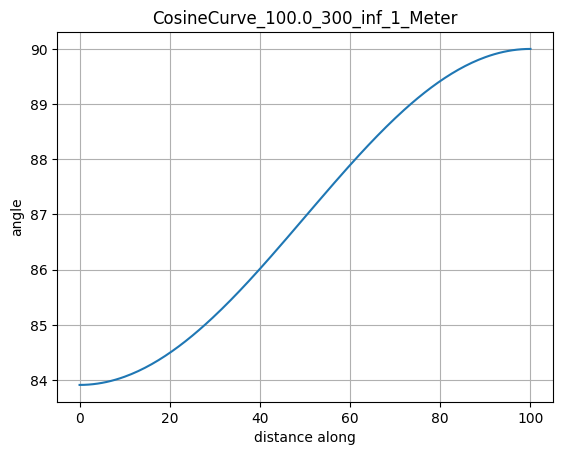

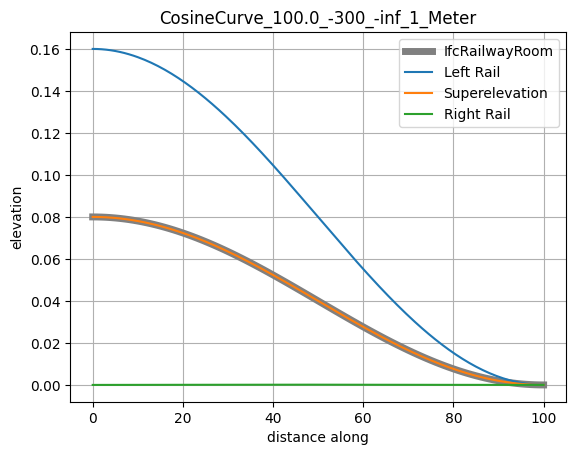

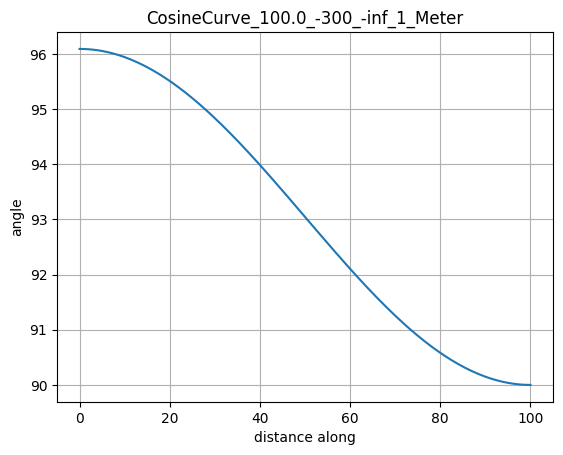

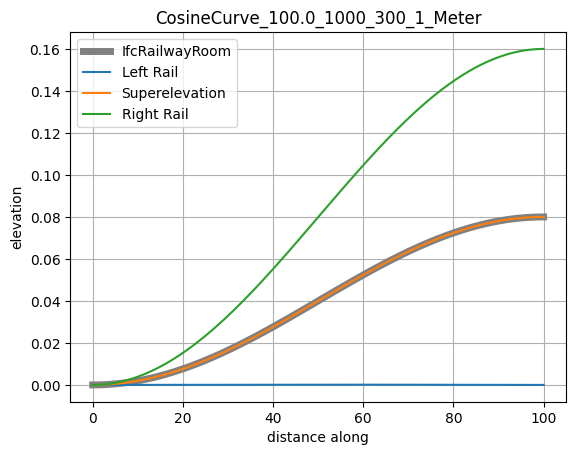

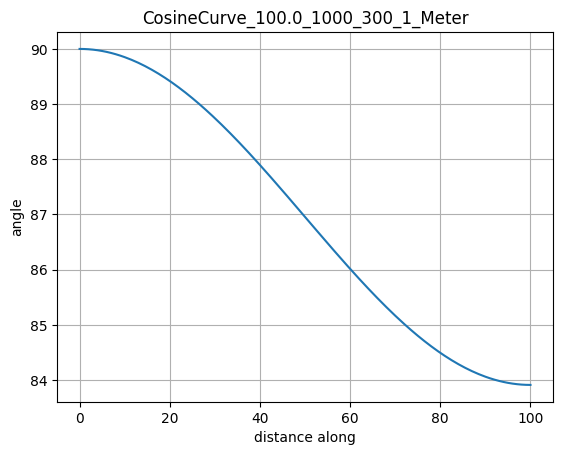

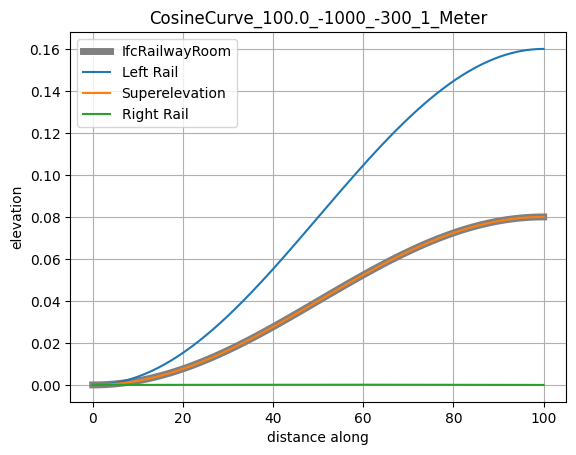

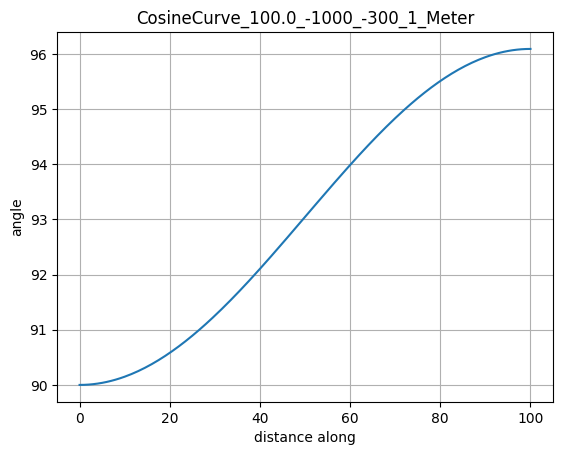

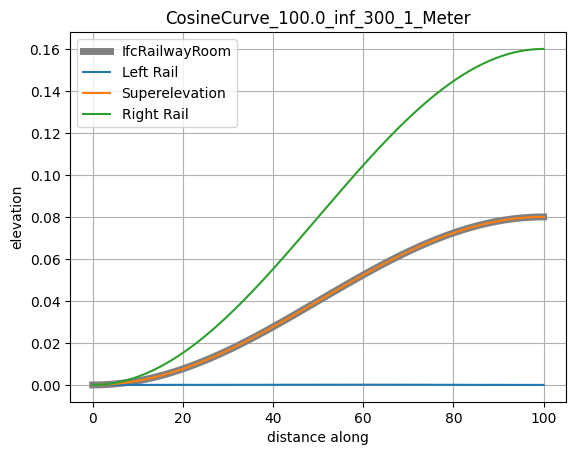

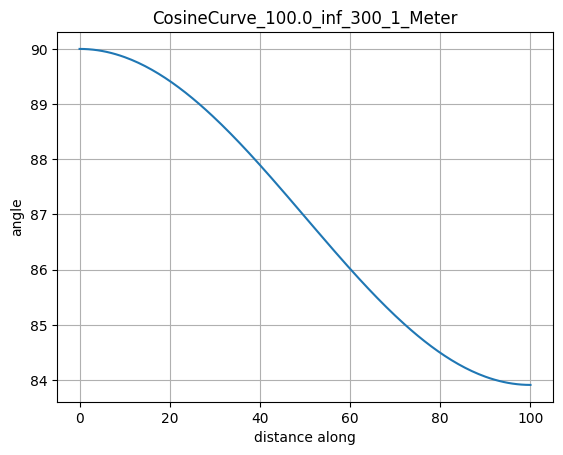

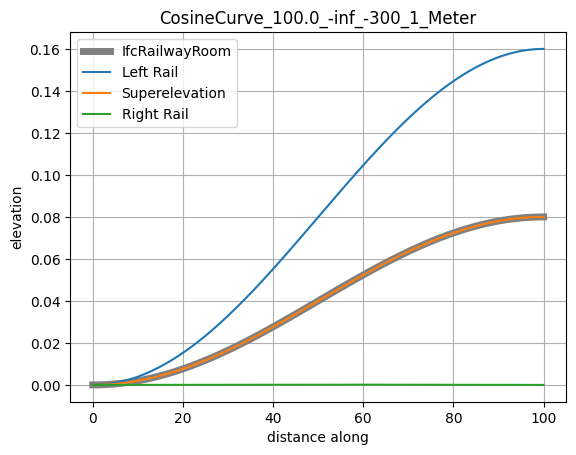

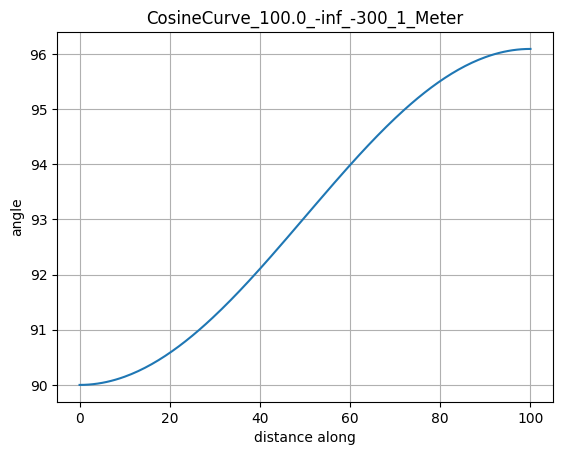

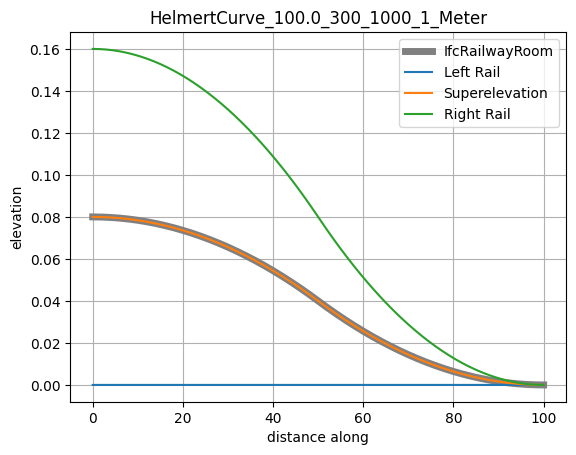

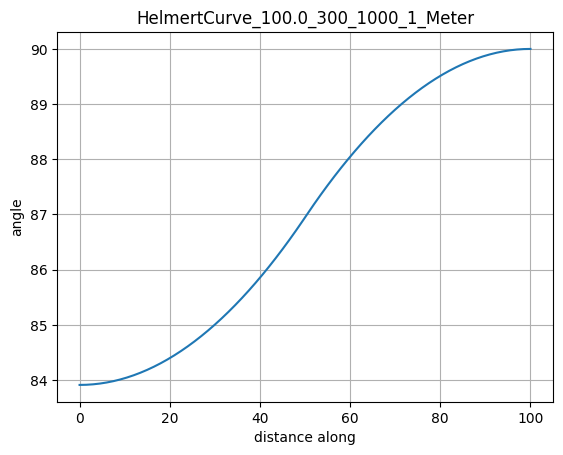

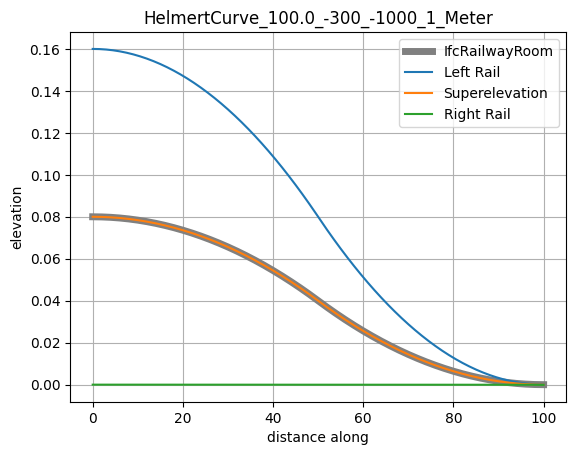

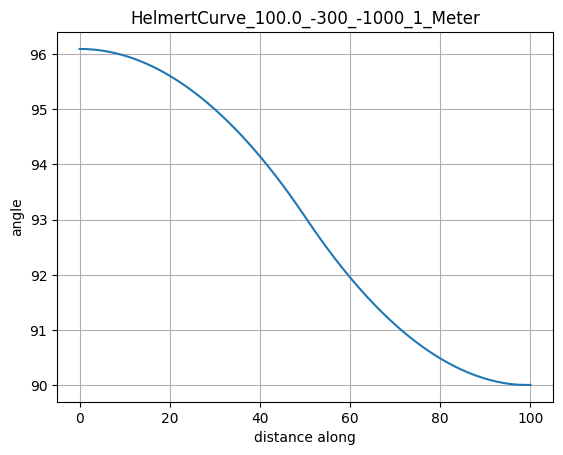

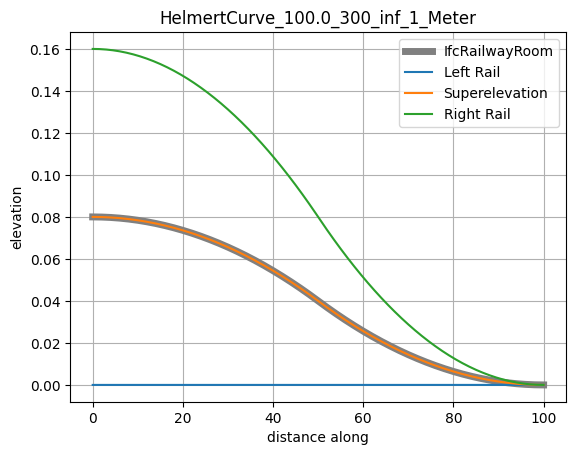

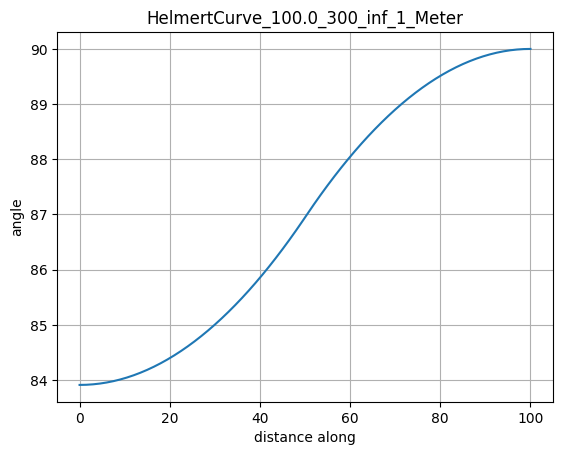

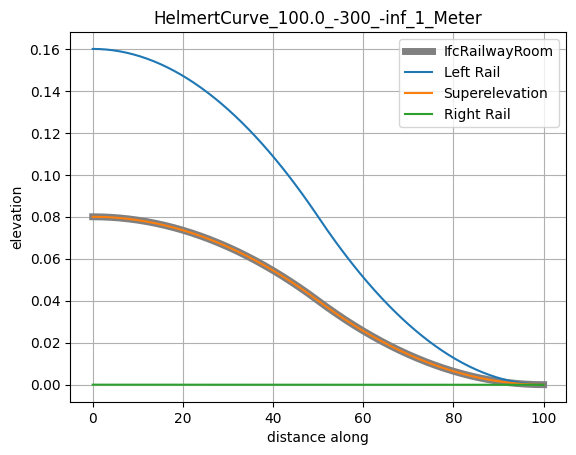

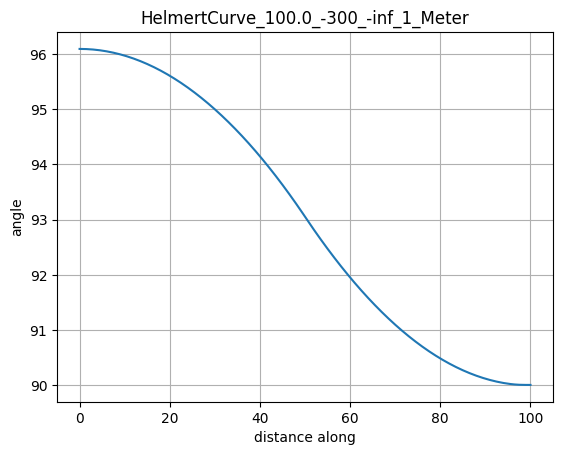

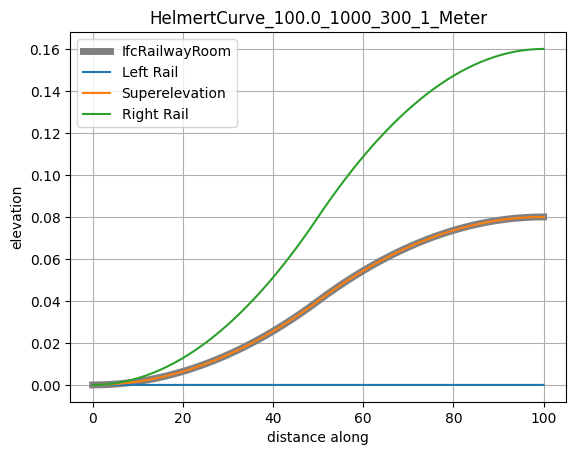

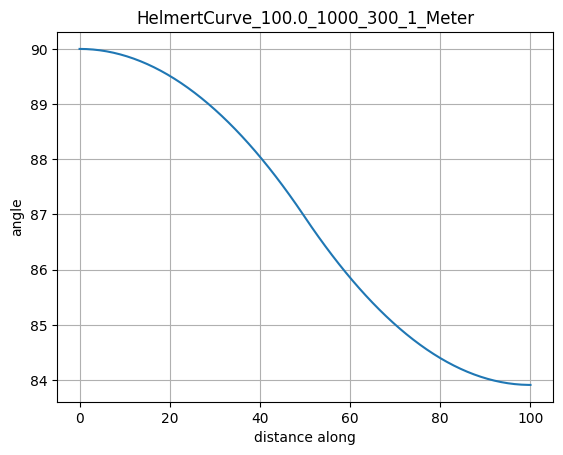

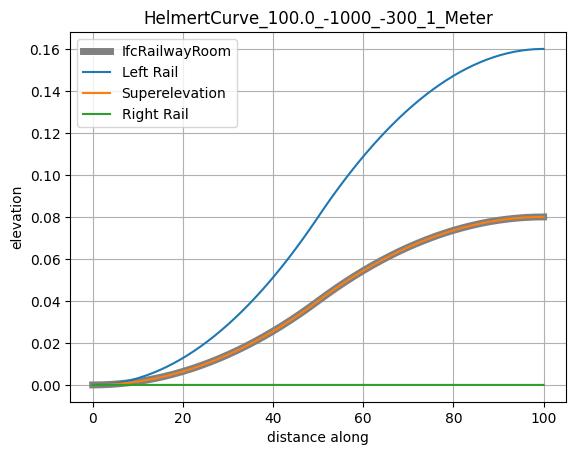

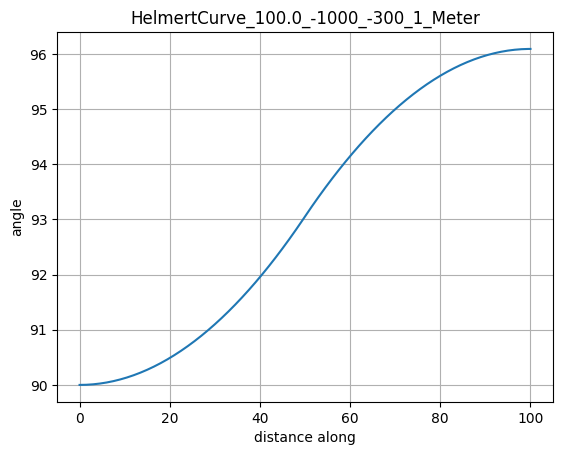

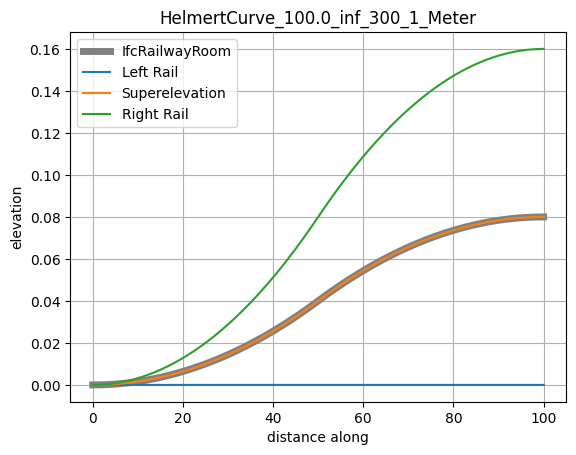

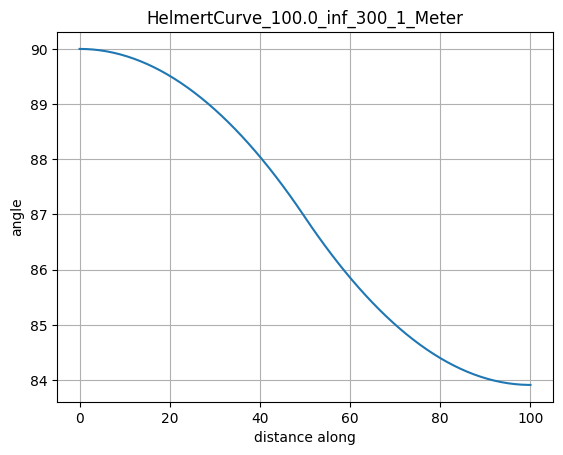

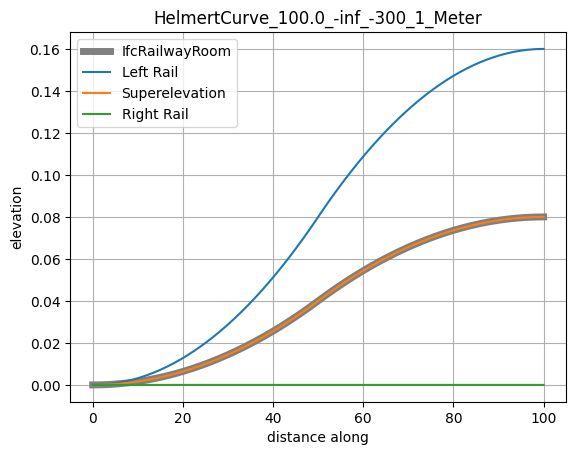

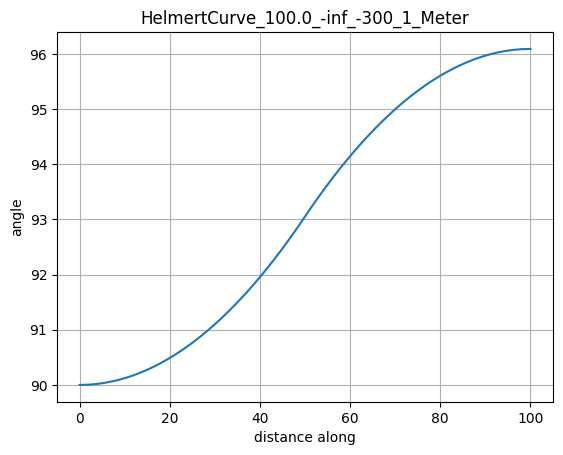

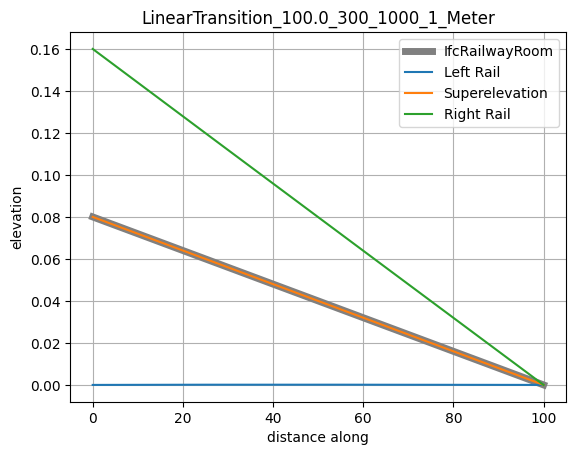

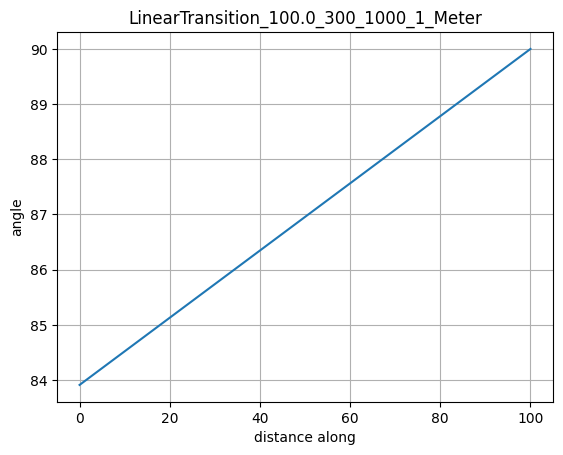

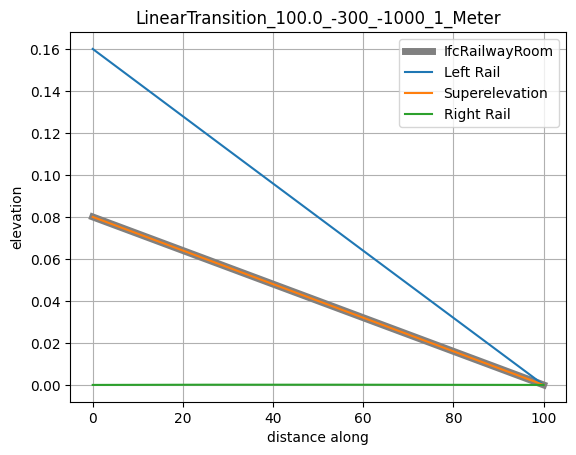

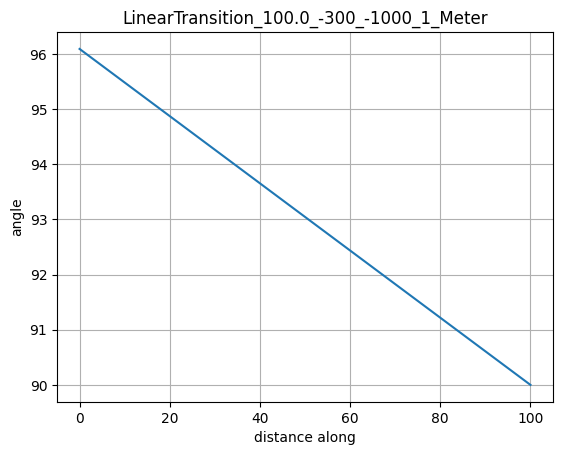

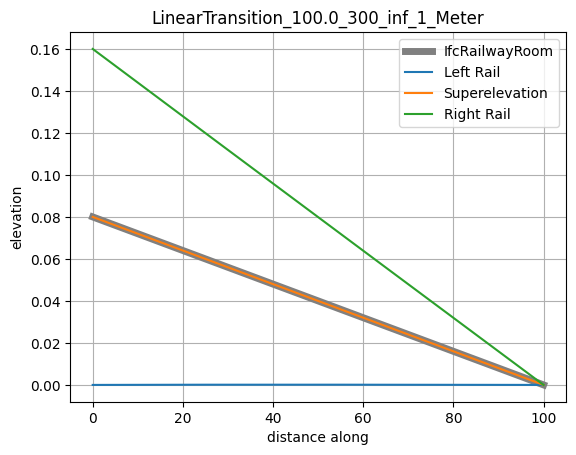

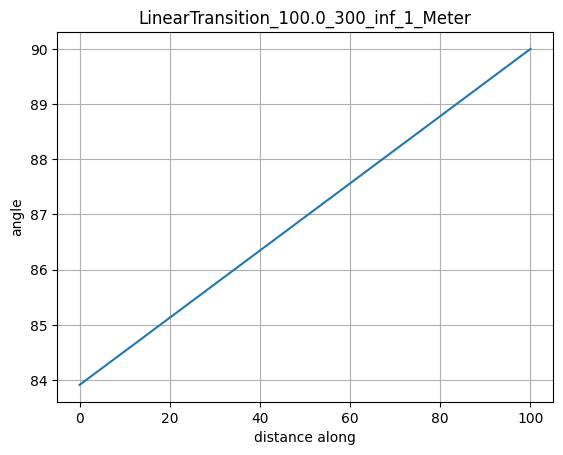

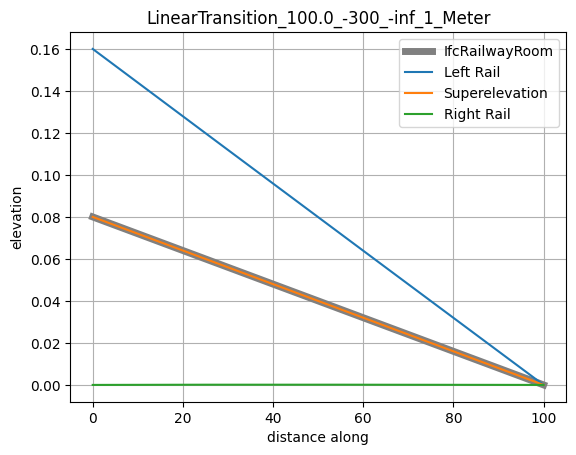

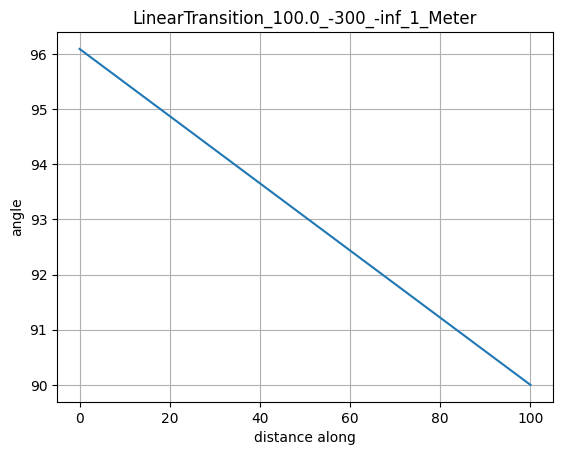

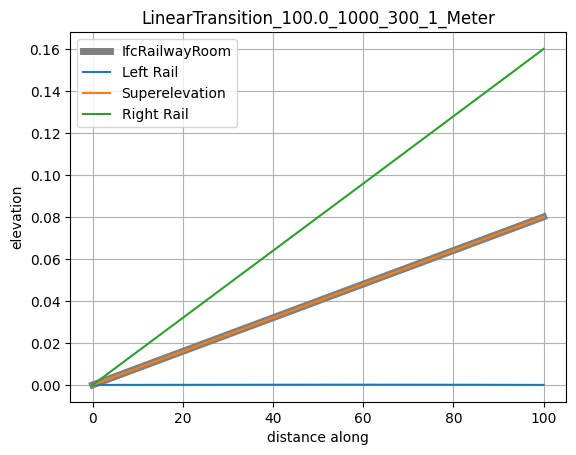

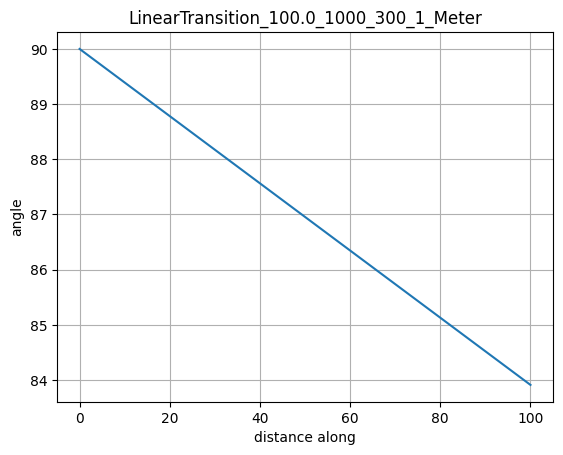

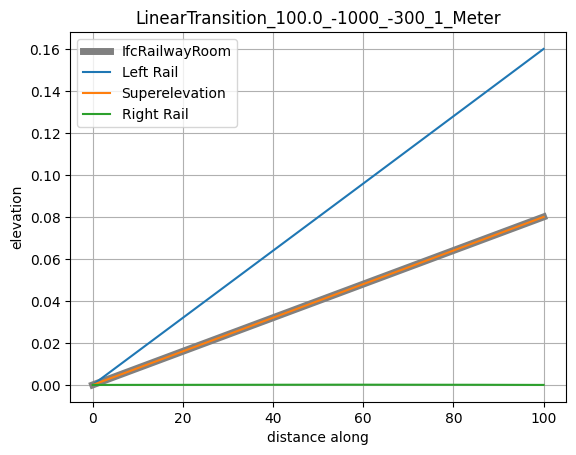

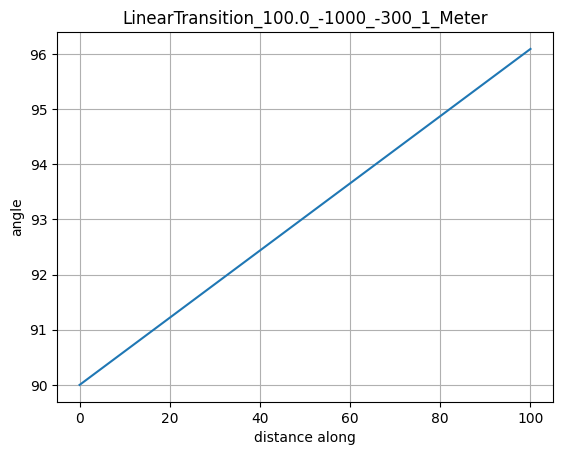

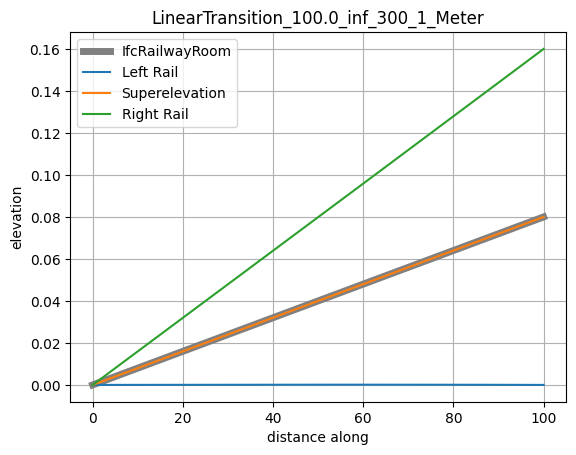

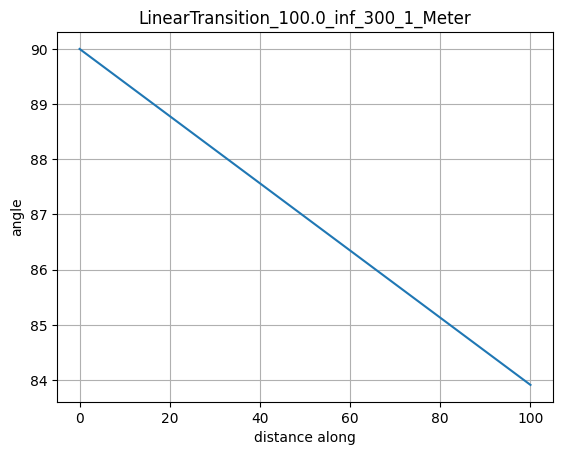

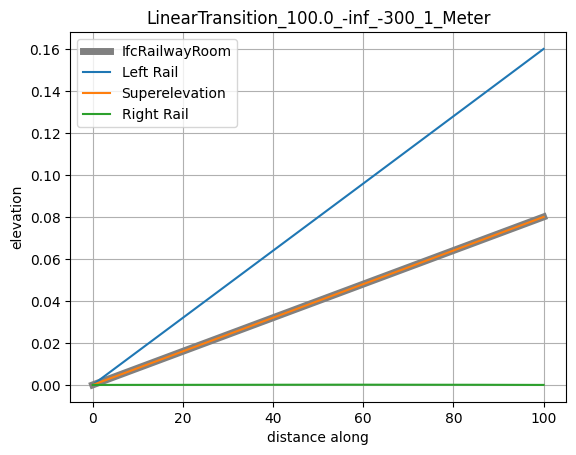

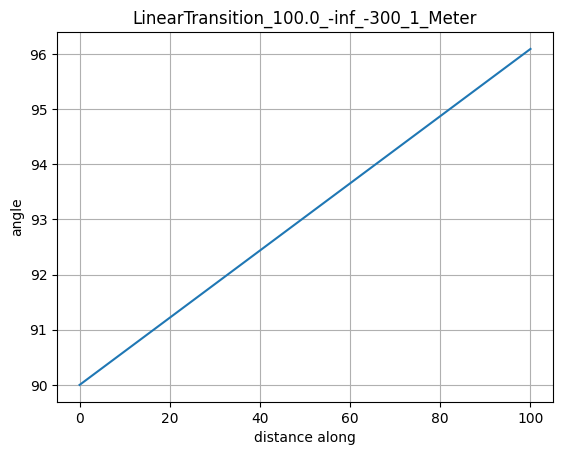

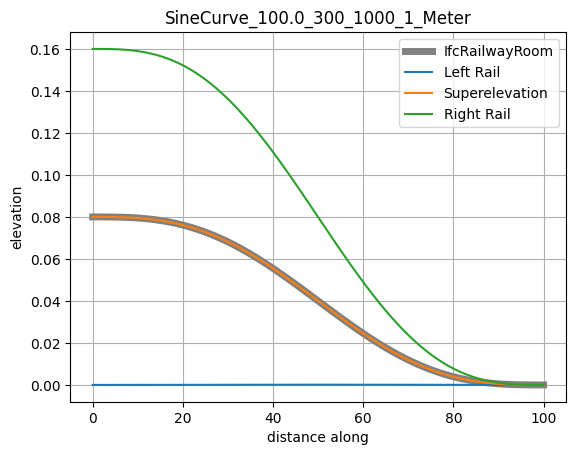

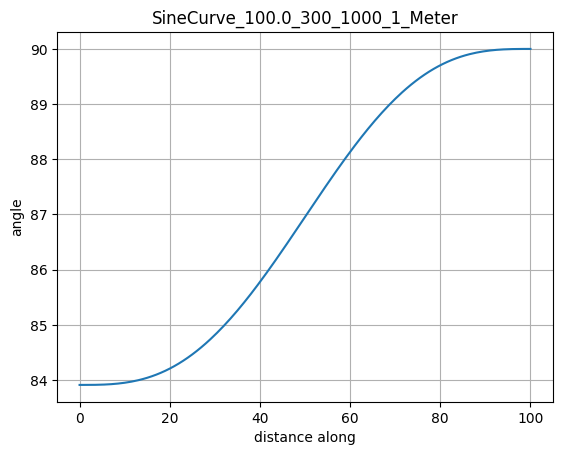

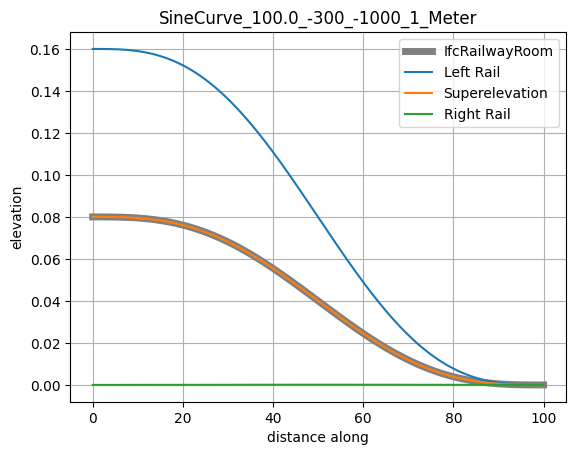

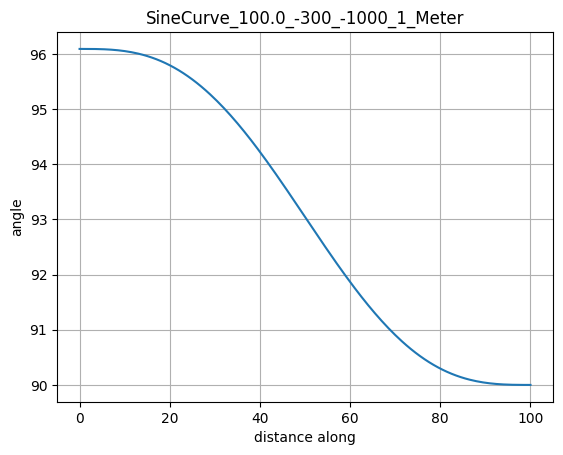

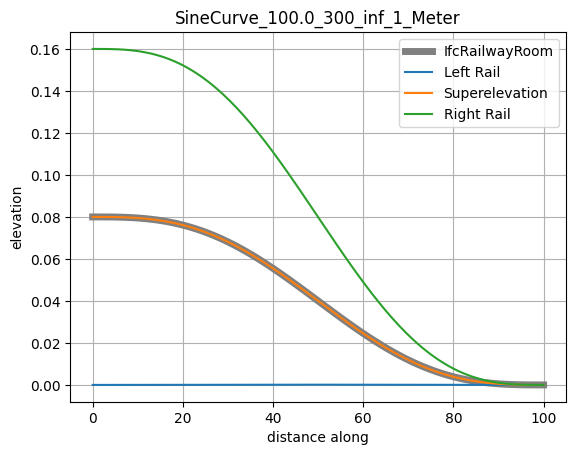

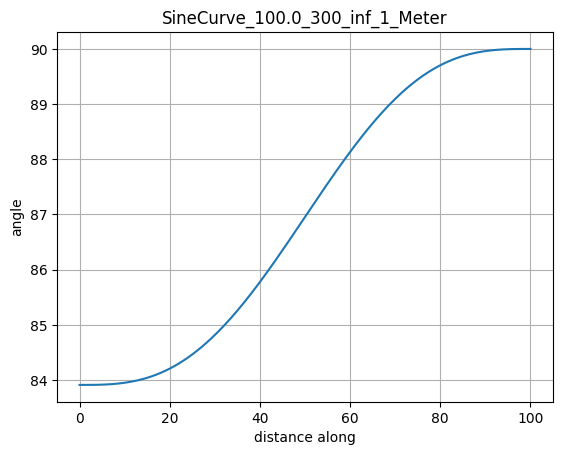

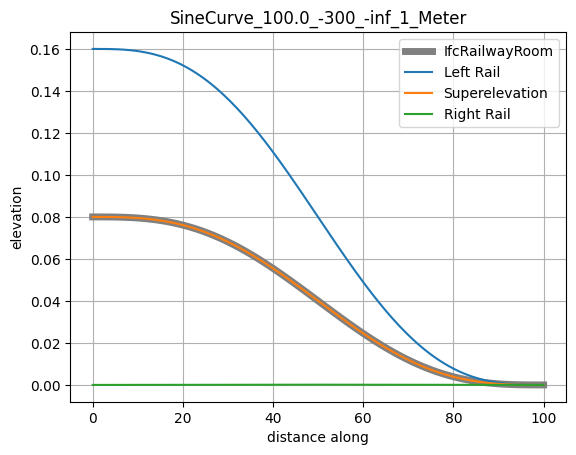

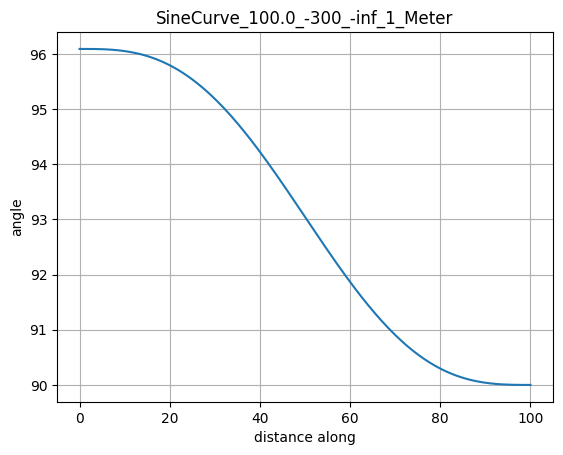

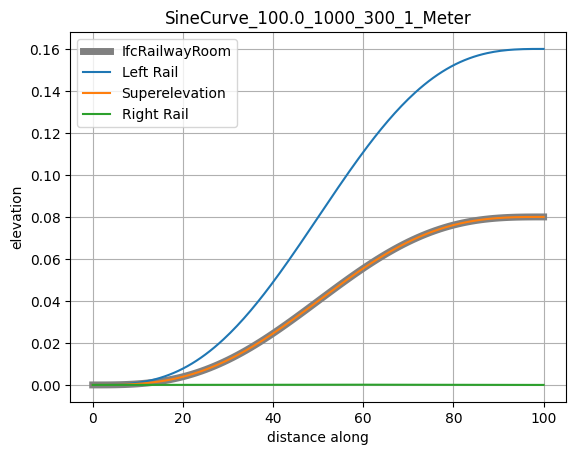

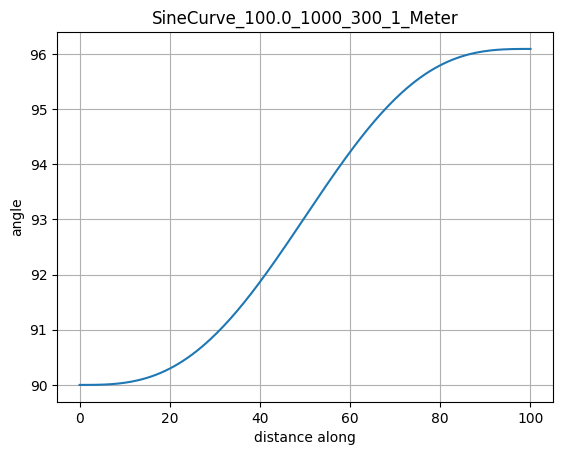

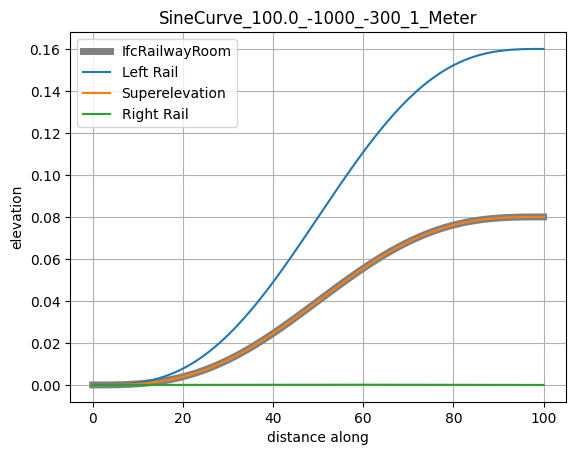

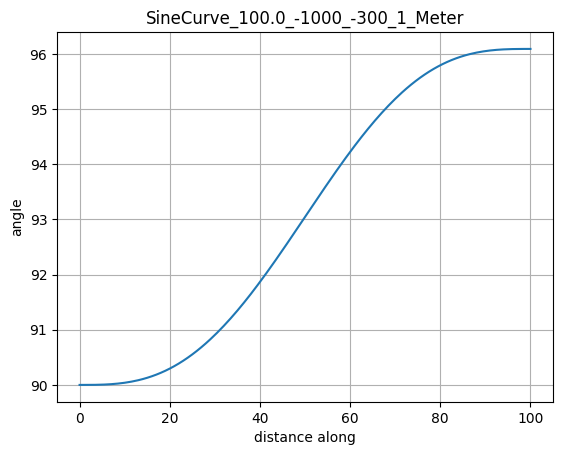

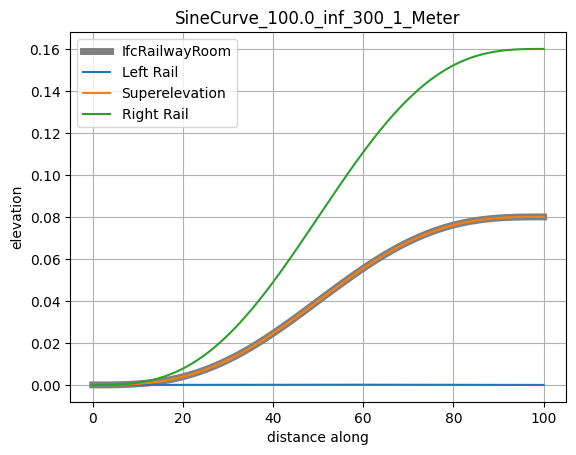

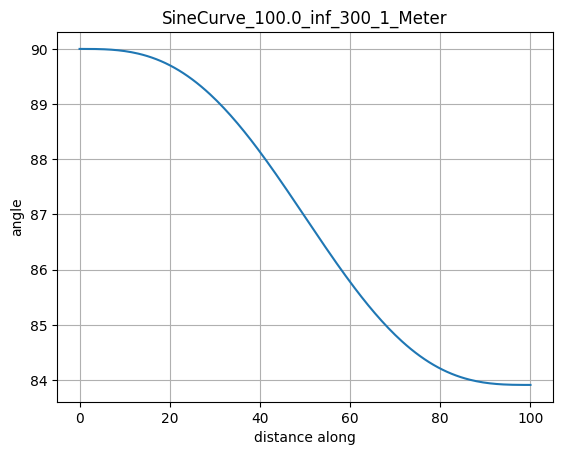

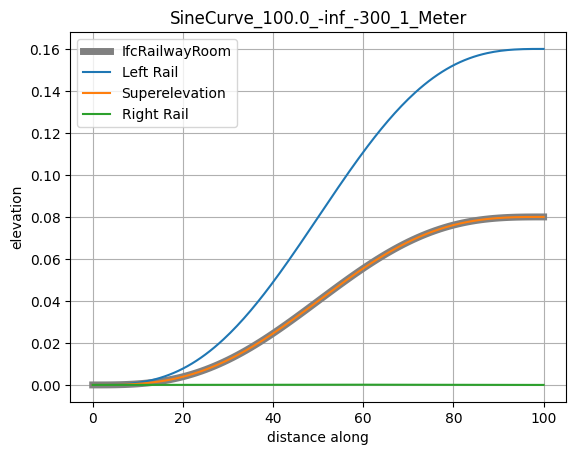

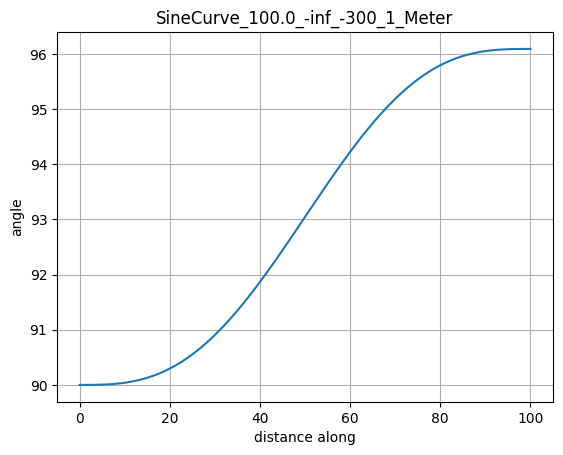

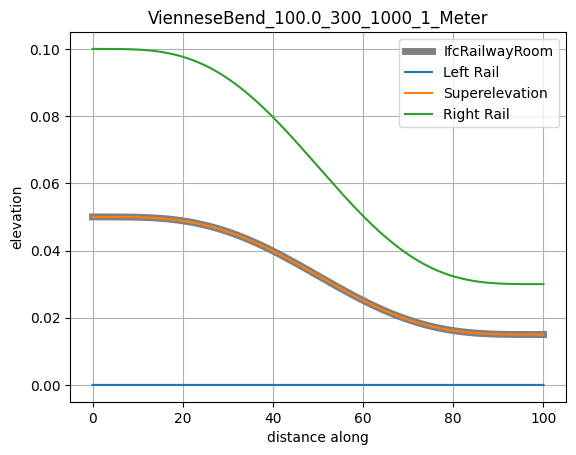

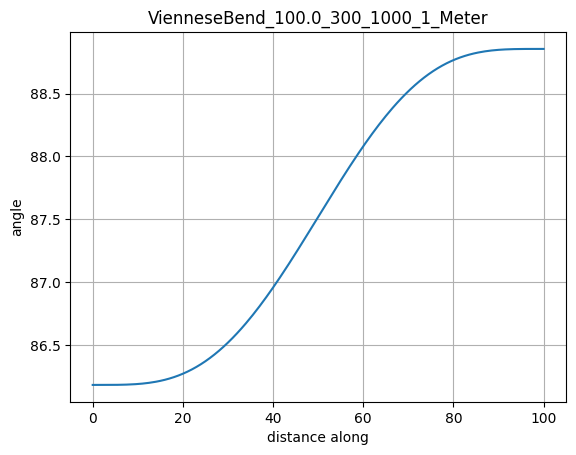

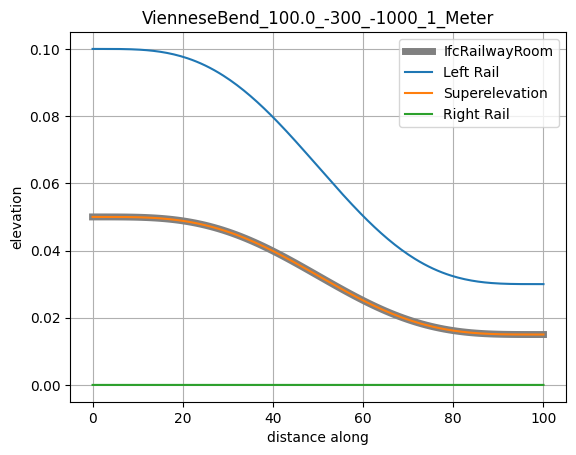

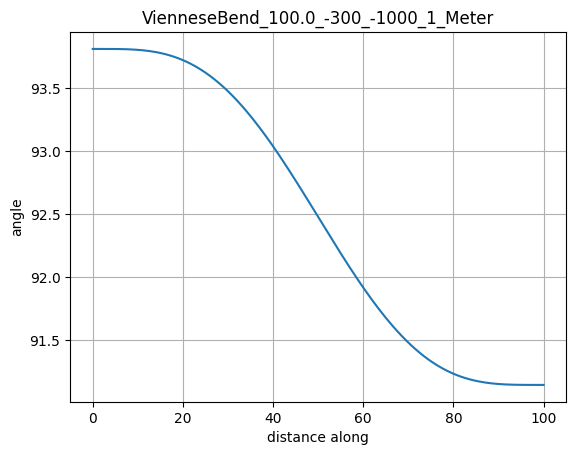

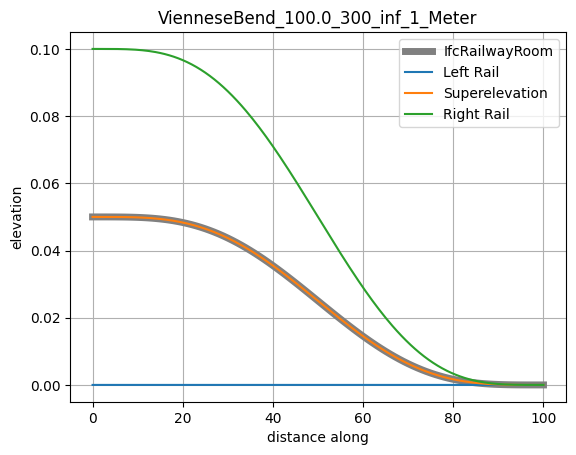

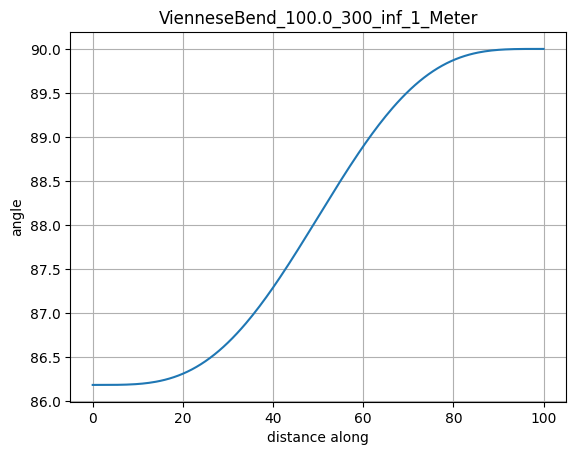

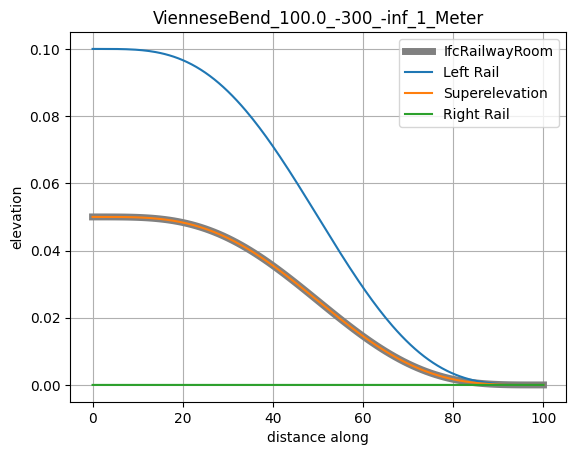

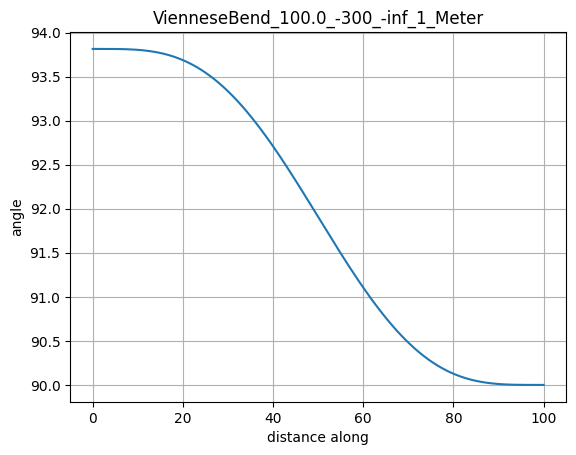

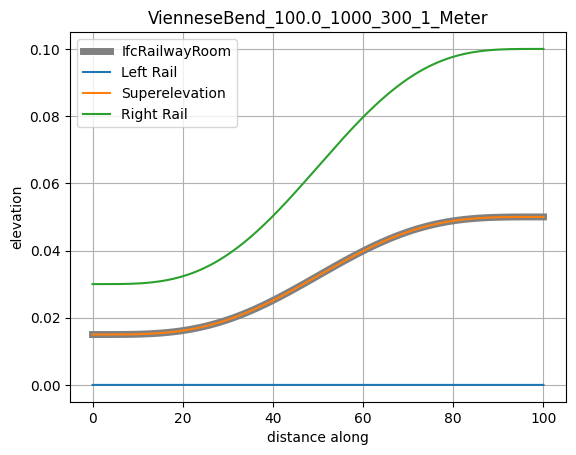

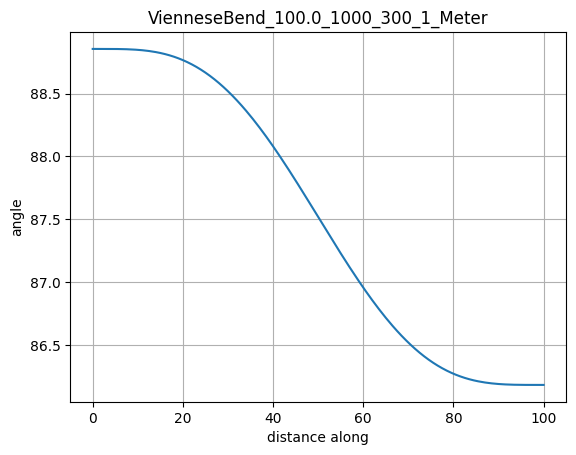

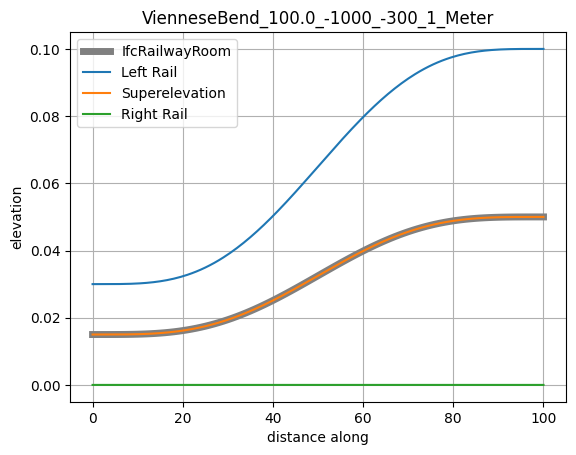

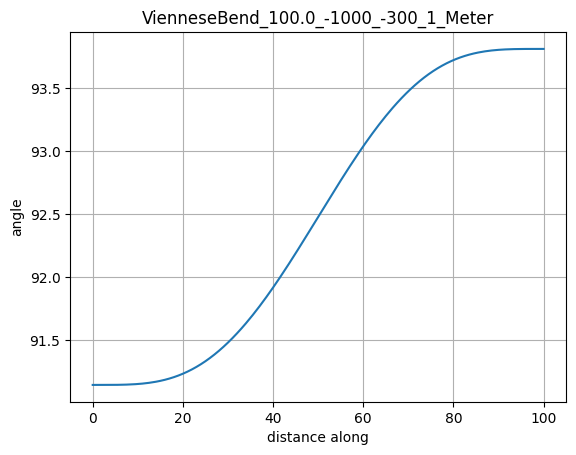

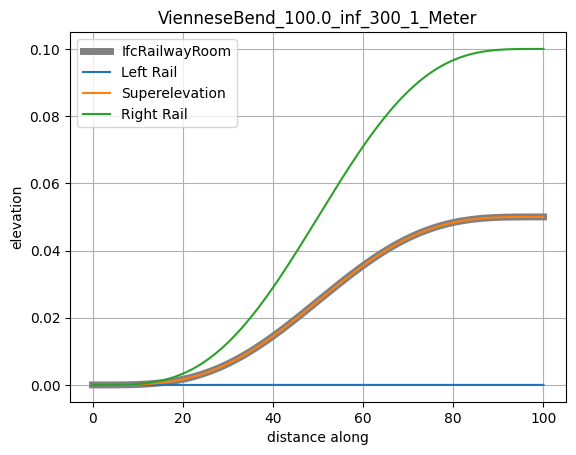

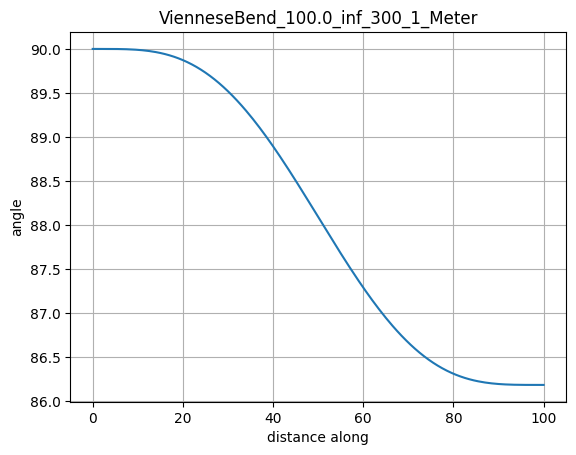

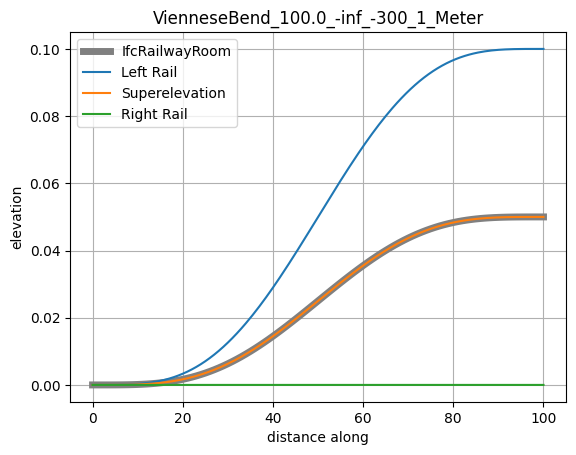

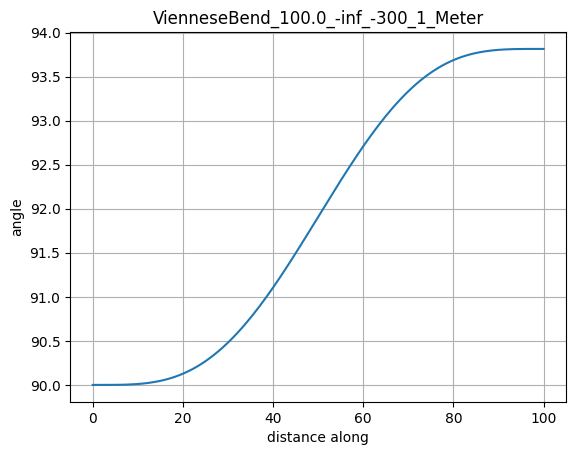

In [4]:
import ifcopenshell, ifcopenshell.geom
import numpy as np
import matplotlib.pyplot as plt
import math

import os
cd = os.getcwd()
drive = os.path.splitdrive(cd)[0]


pi_over_2 = math.pi/2.0

curve_types = ["BlossCurve","ConstantCant","CosineCurve","HelmertCurve","LinearTransition","SineCurve","VienneseBend"]
for curve_type in curve_types:
    test_cases = []
    test_cases.append(curve_type + "_100.0_300_1000_1_Meter")
    test_cases.append(curve_type + "_100.0_-300_-1000_1_Meter")
    test_cases.append(curve_type + "_100.0_300_inf_1_Meter")
    test_cases.append(curve_type + "_100.0_-300_-inf_1_Meter")
    test_cases.append(curve_type + "_100.0_1000_300_1_Meter")
    test_cases.append(curve_type + "_100.0_-1000_-300_1_Meter")
    test_cases.append(curve_type + "_100.0_inf_300_1_Meter")
    test_cases.append(curve_type + "_100.0_-inf_-300_1_Meter")

    #test_cases.append(curve_type + "_100.0_300_1000_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_-300_-1000_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_300_inf_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_-300_-inf_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_1000_300_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_-1000_-300_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_inf_300_1_Meter-2")
    #test_cases.append(curve_type + "_100.0_-inf_-300_1_Meter-2")

    for test_case in test_cases:
        results_file = drive + "/IFC-Rail-Unit-Test-Reference-Code/alignment_testset/ToolboxProcess-C/CantAlignment/" + curve_type + "/" + test_case + "-2CS.txt"
        with open(results_file,'r') as f:
            lines = f.readlines()[2:] # skip the first two header lines
        
        x_values = []
        y_values = []
        for line in lines:
            s,x,y,z = map(float,line.split()[:4])
            d = line.split()[4]
            d = float(d.strip("()"))
            x_values.append(d)
            y_values.append(z)
        
        f = ifcopenshell.open(drive + "/IFC-Rail-Unit-Test-Reference-Code/alignment_testset/IFC-WithGeneratedGeometry/GENERATED__CantAlignment_" + test_case + ".ifc")
        inst = f.by_type('IfcSegmentedReferenceCurve')[0]
        cant = f.by_type('IfcAlignmentCant')[0]
        rail_head = cant.RailHeadDistance
        pwf = ifcopenshell.ifcopenshell_wrapper.map_shape(ifcopenshell.geom.settings(),inst.wrapped_data)
        evaluator = ifcopenshell.ifcopenshell_wrapper.piecewise_function_evaluator(pwf,ifcopenshell.geom.settings())
        locations = evaluator.evaluation_points()
        left = []
        center = []
        right = []
        angle = []
        for u in locations:
            m = evaluator.evaluate(u)
            z = np.array(m)[:,3][2] # get the curve elevation
            axis = np.array(m)[:,2] # get the Axis vector
            #print(axis)
            dx = axis[0]
            dy = axis[1]
            dz = axis[2]

            sign = 1.0
            if dy != 0.0:
                sign = dy/math.fabs(dy)
                
            ds = sign * math.sqrt(dx*dx+dy*dy) # magnitude of vector in cant plane
            left.append(-0.5*rail_head*ds/dz + z)
            center.append(z)
            right.append(0.5*rail_head*ds/dz + z)

            angle.append(math.atan2(dz,ds)*180./math.pi)
        
        fig1 = plt.figure().add_subplot()
        fig1.plot(x_values,y_values,label="IfcRailwayRoom",linewidth=5,color="gray")
        fig1.plot(locations,left,label="Left Rail")
        fig1.plot(locations,center,label="Superelevation")
        fig1.plot(locations,right,label="Right Rail")
                    
        fig1.set_title(test_case)
        fig1.legend()#loc="upper left")
        fig1.set_xlabel("distance along")
        fig1.set_ylabel("elevation")
        fig1.grid(True)

        fig2 = plt.figure().add_subplot()
        fig2.plot(locations,angle)
        fig2.set_title(test_case)
        fig2.set_xlabel("distance along")
        fig2.set_ylabel("angle")
        fig2.grid(True)
        
        plt.show()
